In [ ]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-qzbf1l8k
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-qzbf1l8k
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 133761a90145f77971a08c49bfc7cca318b2df9b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


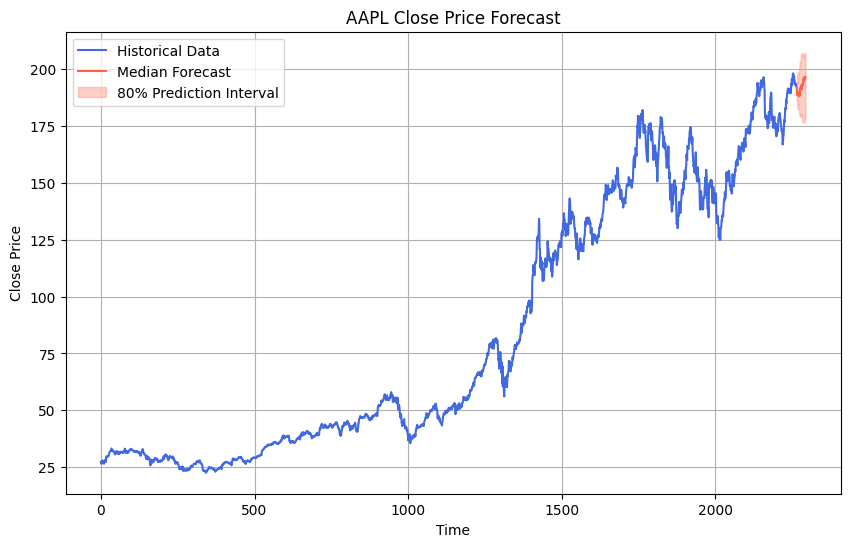

In [ ]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

#Modello CHRONOS
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU
    torch_dtype=torch.bfloat16,
)

#Dati da Yahoo Finance
symbol = "AAPL"  # Sostituisci con il simbolo dell'azione desiderata
data = yf.download(symbol, start="2015-01-01", end="2023-12-31", progress=False)

#Colonna 'Close' come serie temporale
df = data.reset_index()
close_prices = df["Close"].values.reshape(-1)

#Forecasting
forecast = pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=30
)

#Visualizzazione
forecast_index = range(len(close_prices), len(close_prices) + 30)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(close_prices, color="royalblue", label="Historical Data")
plt.plot(forecast_index, median, color="tomato", label="Median Forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

random.seed(seed_value)
tf.random.set_seed(seed_value)

#Scelta variabile risposta (Close) e covariate
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data_filtered = data[features]

#Normalizzazione dati (variabile Close scalata a parte per poter usare normalizzazioni diverse nel caso)
scaler_features = StandardScaler()
scaler_close = StandardScaler()

scaled_features = scaler_features.fit_transform(data_filtered[['Open', 'High', 'Low', 'Volume']])
scaled_close = scaler_close.fit_transform(data_filtered[['Close']])

#Concatenazione delle variabili scalate
scaled_data = np.concatenate((scaled_features, scaled_close), axis=1)

#Creazione sequenze
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps, -1])  #per costruzione la colonna Close è all'ultimo indice
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)

#Training, Validation e Test Set
test_size = 30  #ultimi 30 giorni
val_size = 60   #validazione di 60 giorni

X_train = X[:-(test_size + val_size)]
y_train = y[:-(test_size + val_size)]

X_val = X[-(test_size + val_size):-test_size]
y_val = y[-(test_size + val_size):-test_size]

X_test = X[-test_size:]
y_test = y[-test_size:]

#Costruzione LSTM
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

#Primo layer LSTM con return_sequences=True per avere gli output a ogni timestep
lstm_out1 = LSTM(units=50, return_sequences=True, return_state=True)(inputs)
output_sequence1, hidden_state1, cell_state1 = lstm_out1

#Dropout
dropout1 = Dropout(0.2)(output_sequence1)

#Secondo layer LSTM
lstm_out2 = LSTM(units=50, return_sequences=False, return_state=True)(dropout1)
output_sequence2, hidden_state2, cell_state2 = lstm_out2

#Dropout
dropout2 = Dropout(0.2)(output_sequence2)

#Layer finale
outputs = Dense(1)(dropout2)

#Definizione del modello
model = Model(inputs=inputs, outputs=outputs)

#Compilazione del modello
model.compile(optimizer='adam', loss='mean_squared_error')

#Addestramento del modello con Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

hidden_state_model_1 = Model(inputs=inputs, outputs=hidden_state1)
hidden_states_full_1 = hidden_state_model_1.predict(X)

hidden_state_model_2 = Model(inputs=inputs, outputs=hidden_state2)
hidden_states_full_2 = hidden_state_model_2.predict(X)

#Selezione degli hidden states dal secondo layer
hidden_states = hidden_states_full_2  #(num_samples, units)

#Calcolo della norma L2 degli hidden states per ogni campione
hidden_state_norm = np.linalg.norm(hidden_states, axis=1)  #(num_samples,)

#Normalizzaziome dei valori
scaler_weights = StandardScaler()
weights = scaler_weights.fit_transform(hidden_state_norm.reshape(-1, 1)).flatten()
weights = weights.flatten()

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1842 - val_loss: 0.0220
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0161 - val_loss: 0.0116
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0137 - val_loss: 0.0099
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0128 - val_loss: 0.0099
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0122 - val_loss: 0.0100
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0105 - val_loss: 0.0087
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0103 - val_loss: 0.0083
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - val_loss: 0.0107
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 

Dimensione close_prices: 2204
Dimensione weights: 2204


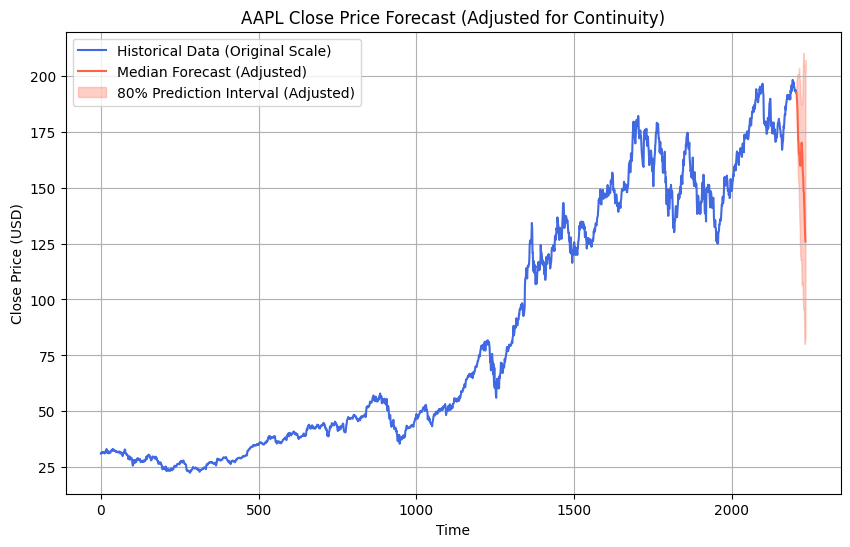

In [ ]:
#Per avere stessa lunghezza (time_steps "toglie" i primi n dati)
close_prices = close_prices.reshape(-1, 1)
close_prices = close_prices[time_steps:]

#######################################
# PASSO 1: Scalare i dati
#######################################
scaler_close = StandardScaler()
scaled_close_prices = scaler_close.fit_transform(close_prices)  #(n_samples, 1)

#######################################
# PASSO 2: Applicare i pesi
#######################################
#I pesi e i close_prices devono avere la stessa lunghezza
print("Dimensione close_prices:", len(scaled_close_prices))
print("Dimensione weights:", len(weights))

#Combinazione di prezzi e pesi
weighted_close_values = scaled_close_prices.flatten() * weights
weighted_close_values = weighted_close_values.reshape(-1)  #per assicurarsi che sia della forma (n_samples,)

#######################################
# PASSO 3: Previsione con CHRONOS
#######################################
context_tensor = torch.tensor(weighted_close_values, dtype=torch.float32)
prediction_length = 30

forecast = pipeline.predict(
    context=context_tensor,
    prediction_length=prediction_length
)

forecast_index = range(len(weighted_close_values), len(weighted_close_values) + prediction_length)
low, median, high = np.quantile(forecast[0].detach().cpu().numpy(), [0.1, 0.5, 0.9], axis=0)

#######################################
# PASSO 4: Tornare alla scala originale (le previsioni sono nella scala dei dati pesati e scalati)
#######################################

median_original = scaler_close.inverse_transform(median.reshape(-1, 1)).flatten()
low_original = scaler_close.inverse_transform(low.reshape(-1, 1)).flatten()
high_original = scaler_close.inverse_transform(high.reshape(-1, 1)).flatten()

close_prices_original = close_prices.flatten()  #close_prices era già in scala originale prima

#######################################
# PASSO 5: Aggiustamento per la continuità
#######################################
# Ultimo valore storico
last_value = close_prices_original[-1]  #Valore reale

# Primo valore previsto (scala originale)
first_forecasted_value = median_original[0]

# Calibrazione del primo valore predetto
adjustment = last_value - first_forecasted_value  #differenza tra reale e previsto
median_original = median_original + adjustment   #aggiustamento delle previsioni
low_original = low_original + adjustment         #aggiustamento dell'intervallo inferiore
high_original = high_original + adjustment       #aggiustamento dell'intervallo superiore

#######################################
# PASSO 6: Visualizzazione
#######################################
plt.figure(figsize=(10, 6))
plt.plot(close_prices_original, color="royalblue", label="Historical Data (Original Scale)")
plt.plot(forecast_index, median_original, color="tomato", label="Median Forecast (Adjusted)")
plt.fill_between(forecast_index, low_original, high_original, color="tomato", alpha=0.3, label="80% Prediction Interval (Adjusted)")
plt.title(f"{symbol} Close Price Forecast (Adjusted for Continuity)")
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid()
plt.show()